<a href="https://colab.research.google.com/github/digs1998/Deep-Learning-Implementations/blob/master/SurgeonsLab_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install pydicom
!pip install SimpleITK

In [3]:
#!python -m pip uninstall matplotlib
#!pip install matplotlib==3.1.3

# Loading Libraries

In [26]:
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pydicom as dcm
import cv2
from PIL.Image import fromarray
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from medpy.io import load
import SimpleITK as sitk
import nibabel as nib

from pydicom.pixel_data_handlers.util import apply_voi_lut
import shutil
from pathlib import Path

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Converting Dicom to PNG 

In [5]:
path = '/content/drive/MyDrive/Anonymized Dicom Data/'
outpath = '/content/drive/MyDrive/Cerebral Aneurysm PNG-20210614T125150Z-001/Train/'

dcmlist = [f for f in os.listdir(path)]

def dicom2png(source_folder, output_folder):
  for x in dcmlist:
    img = sitk.ReadImage(path + x)
    # rescale intensity range from [-1000,1000] to [0,255]
    img = sitk.IntensityWindowing(img, -1000, 1000, 0, 255)
    # convert 16-bit pixels to 8-bit
    img = sitk.Cast(img, sitk.sitkUInt8)

    sitk.WriteImage(img, outpath + x.replace(".IMA",".png"))

In [6]:
#dicom2png(path, outpath)

##Visualizing Images

In [7]:
imgs = [cv2.imread(outpath + i) for i in os.listdir(outpath)]
cells = np.array(imgs)

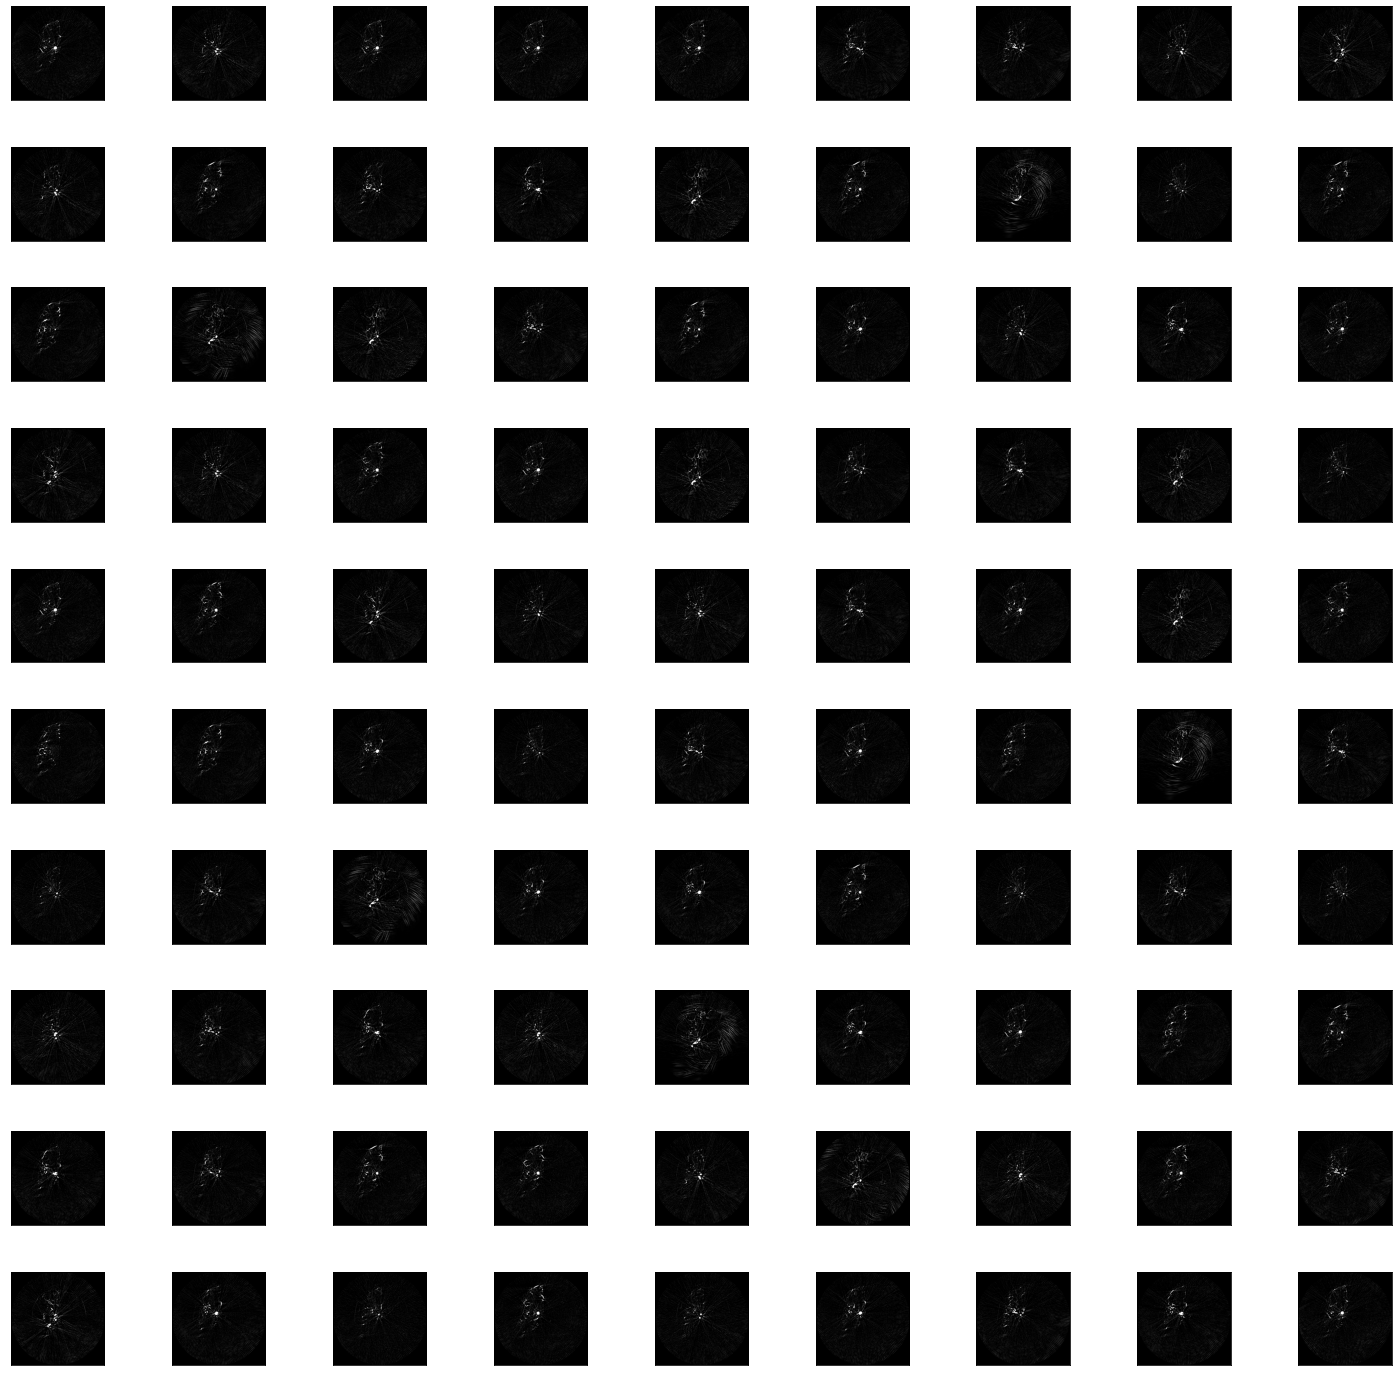

In [8]:
plt.figure(1 , figsize = (25 ,25))
n = 0 
for i in range(90):
    n += 1 
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(10,9,n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(cells[r[0]])
    plt.xticks([]) , plt.yticks([])
    
plt.show()

##Dataset Processing
- Loading scans of all dicom files
- calculating the 3d values of scans using pixel spacing and dimensions
- plotting images based on it

In [9]:
scan = []
def load_scan(path):
  for dirName, subDirlist, fileList in os.walk(path):
    for filename in fileList:
      if '.IMA' in filename.upper():
        scan.append(os.path.join(dirName, filename))
        #print(scan)
  return scan

patient = load_scan(path)
#print(patient)  

In [10]:
refds = dcm.read_file(scan[0])
constpixeldims = (int(refds.Rows),int(refds.Columns), len(scan))
constpixelspacing = (float(refds.PixelSpacing[0]),float(refds.PixelSpacing[1]),
                     float(refds.SliceThickness))

x = np.arange(0.0, (constpixeldims[0]+1)*constpixelspacing[0],constpixelspacing[0])
y = np.arange(0.0, (constpixeldims[1]+1)*constpixelspacing[1],constpixelspacing[1])
z = np.arange(0.0, (constpixeldims[2]+1)*constpixelspacing[2],constpixelspacing[2])

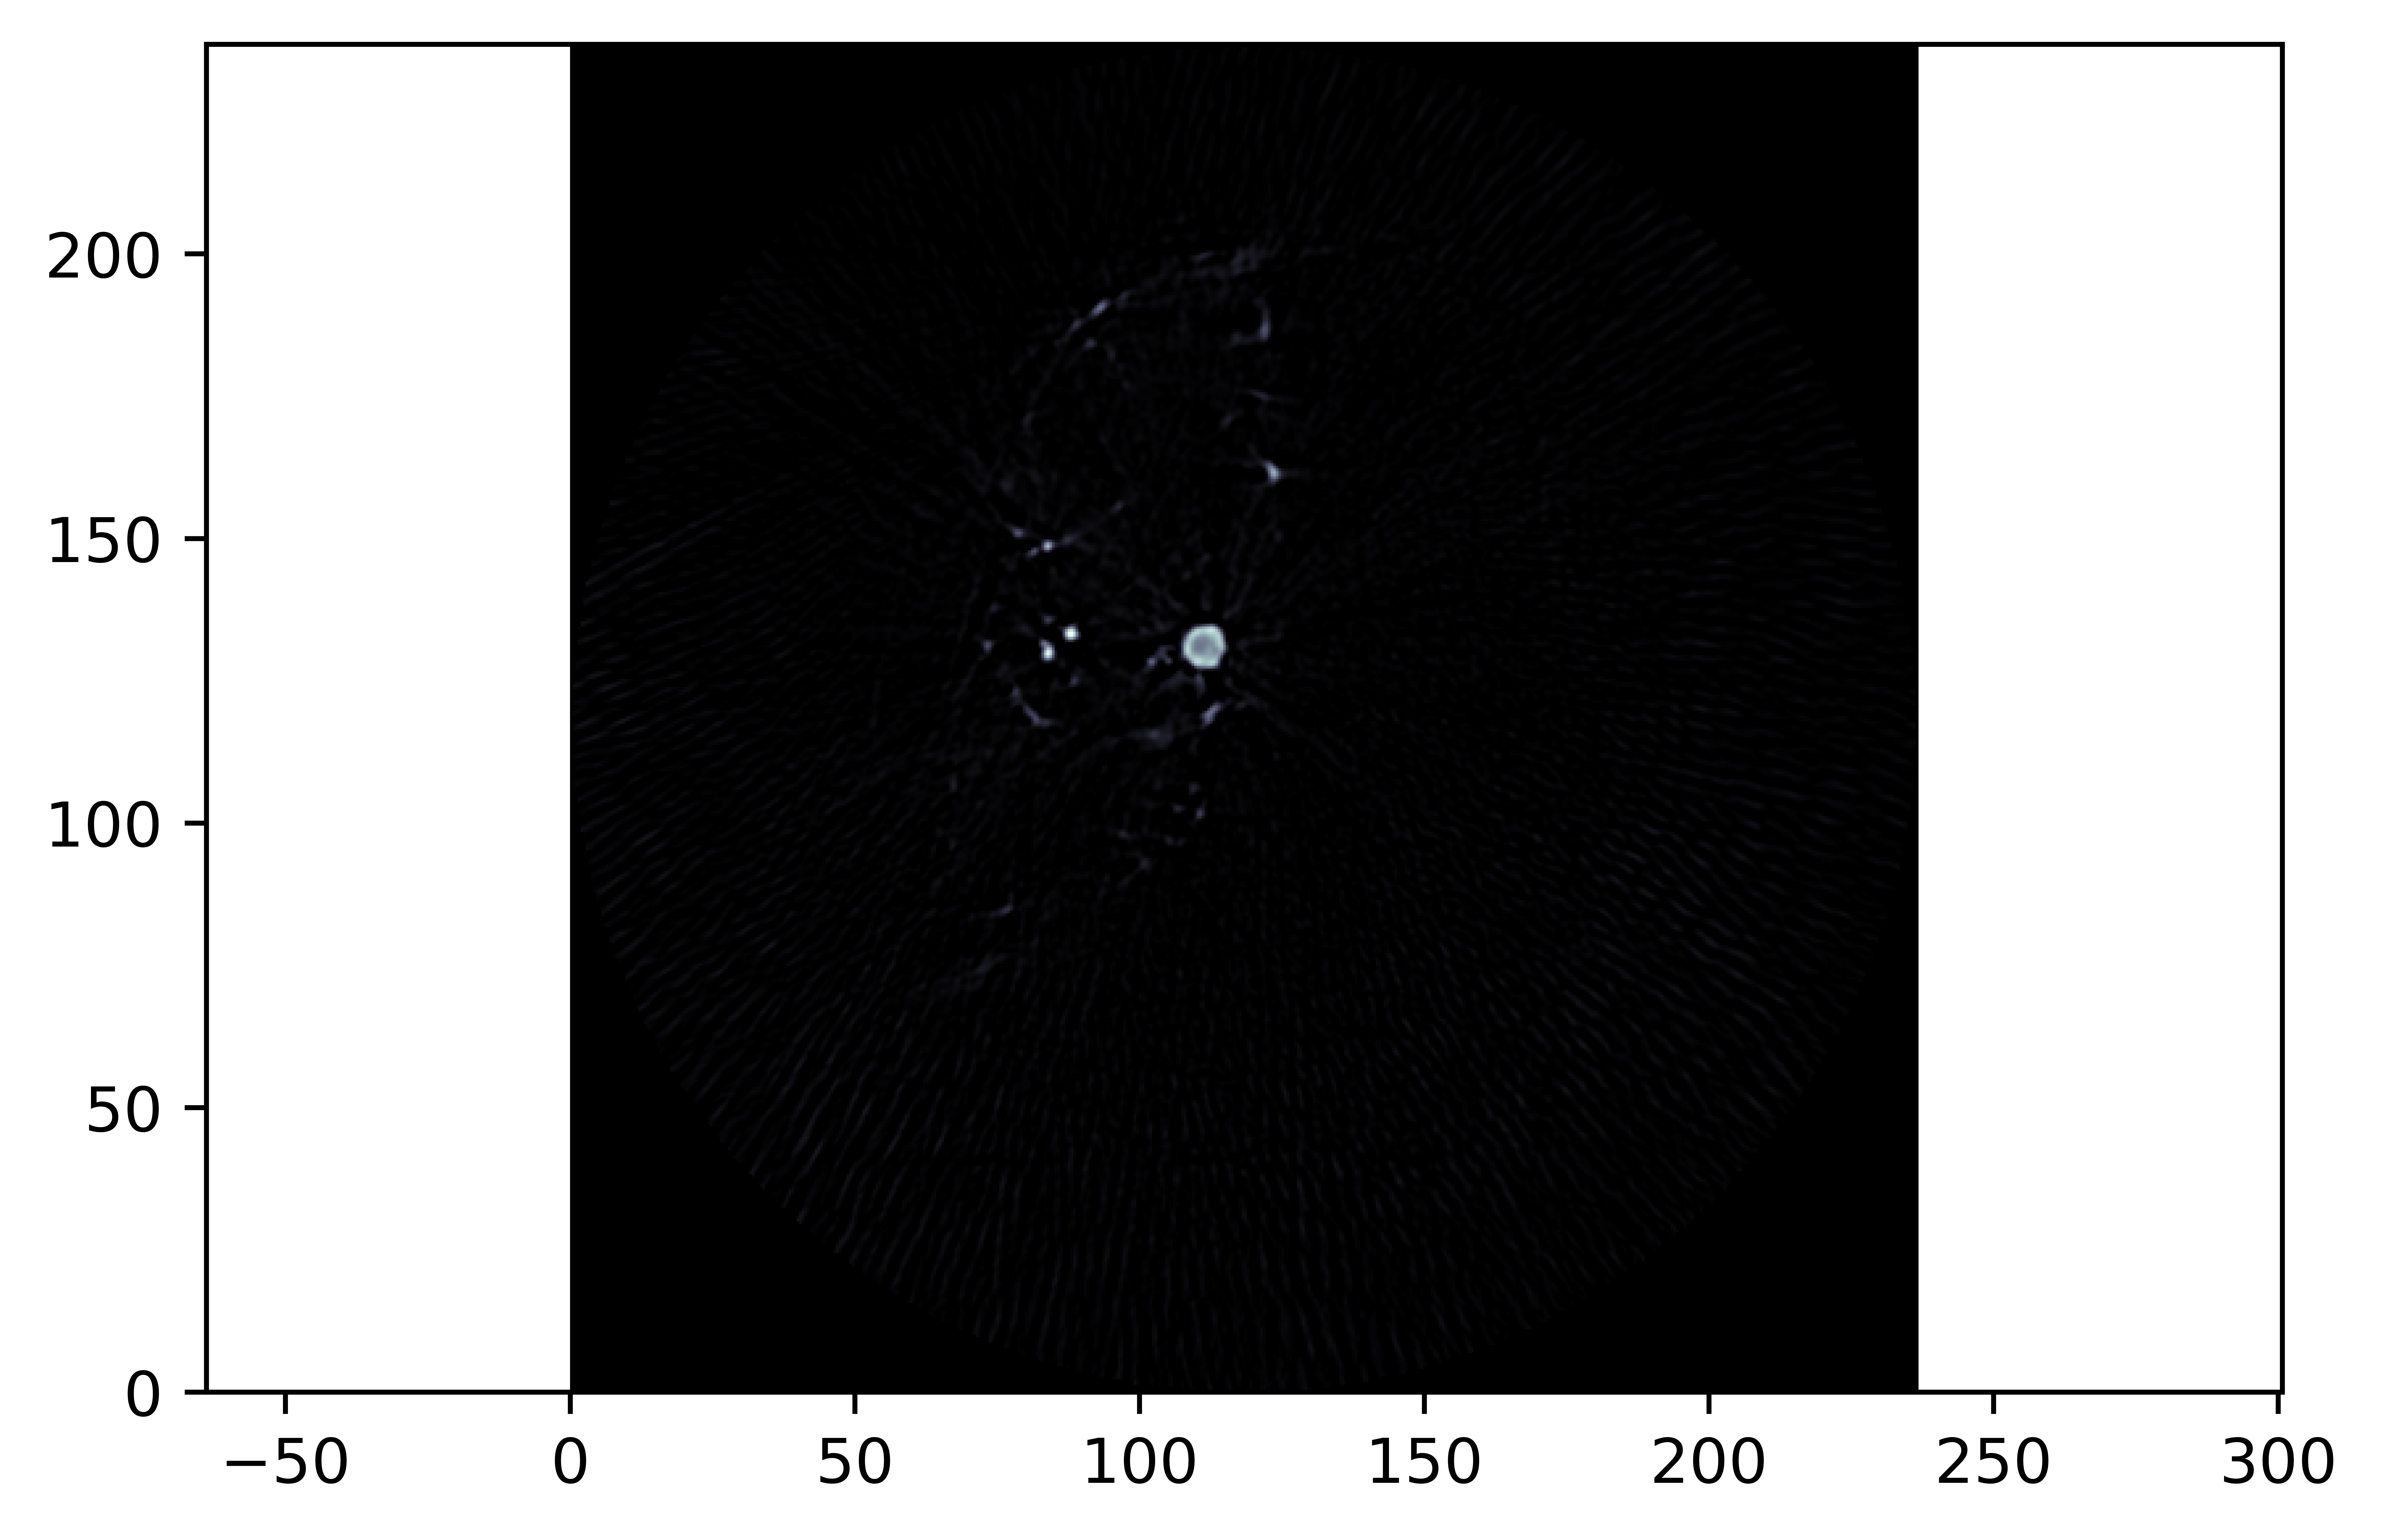

In [11]:
ArrayDicom = np.zeros(constpixeldims, dtype=refds.pixel_array.dtype)

for i in scan:
  ds = dcm.read_file(i)
  #store the raw image data
  ArrayDicom[:,:,scan.index(i)] = ds.pixel_array

plt.figure(dpi=1600)
plt.axes().set_aspect('equal','datalim')
plt.set_cmap(plt.cm.bone)
plt.pcolormesh(x,y,np.flipud(ArrayDicom[:,:,20]))

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   validation_split=0.25)

In [31]:
train_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Cerebral Aneurysm PNG-20210614T125150Z-001/',
                                              target_size = (512, 512),
                                              batch_size = 32,
                                              class_mode = 'binary'
                                                )
# for test data
test_set = train_datagen.flow_from_directory('/content/drive/MyDrive/Cerebral Aneurysm PNG-20210614T125150Z-001/',
                                            target_size = (512,512),
                                            class_mode = 'binary'
                                           )

Found 83 images belonging to 2 classes.
Found 83 images belonging to 2 classes.


##VGGNet

In [20]:
IMAGE_SIZE = [512,512]
vgg = tf.keras.applications.VGG16(input_shape = IMAGE_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

In [21]:
#removing last layer
folder = glob.glob('/content/drive/MyDrive/Cerebral Aneurysm PNG-20210614T125150Z-001/')
x = Flatten()(vgg.output)
preds = Dense(512, activation='relu')(x)
predictions = Dense(len(folder), activation='softmax')(preds)

vgg_model = Model(inputs=vgg.input, outputs=predictions)

In [22]:
vgg_model.compile(loss='binary_crossentropy',
  optimizer='adam',
  metrics='accuracy')

##Performance

In [27]:
filepath = "vgg16_model.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = vgg_model.fit_generator(train_set, 
                              #class_weight=class_weights,
                    validation_data=test_set,
                    epochs=30, 
                    verbose=1,
                   #callbacks=callbacks_list
                   )

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
3/3 [==============================] - 4s 2s/step - loss: 9.4787e-06 - accuracy: 0.1205 - val_loss: 8.0026e-06 - val_accuracy: 0.1205
Epoch 2/30
3/3 [==============================] - 4s 2s/step - loss: 7.4407e-06 - accuracy: 0.1205 - val_loss: 6.5409e-06 - val_accuracy: 0.1205
Epoch 3/30
3/3 [==============================] - 4s 2s/step - loss: 6.1883e-06 - accuracy: 0.1205 - val_loss: 5.6086e-06 - val_accuracy: 0.1205
Epoch 4/30
3/3 [==============================] - 4s 2s/step - loss: 5.1749e-06 - accuracy: 0.1205 - val_loss: 4.9923e-06 - val_accuracy: 0.1205
Epoch 5/30
3/3 [==============================] - 4s 2s/step - loss: 4.9922e-06 - accuracy: 0.1205 - val_loss: 4.5544e-06 - val_accuracy: 0.1205
Epoch 6/30
3/3 [==============================] - 4s 2s/step - loss: 4.4422e-06 - accuracy: 0.1205 - val_loss: 4.2463e-06 - val_accuracy: 0.1205
Epoch 7/30
3/3 [==============================] - 4s 2s/step - loss: 4.1647e-06 - accuracy: 0.1205 - val_loss: 4.0198e-06 - val_ac

##Predictions

In [28]:
y_pred = vgg_model.predict_generator(test_set)

y_pred = np.argmax(y_pred, axis=1)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])